In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import bs4 as bs
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from keras.preprocessing.text import text_to_word_sequence
import urllib.request
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Dataset
raw_html = urllib.request.urlopen('https://en.wikipedia.org/wiki/Democracy')
raw_html = raw_html.read()
article_html = bs.BeautifulSoup(raw_html, 'lxml')
article_paragraphs = article_html.find_all('p')
article_text = ''
for para in article_paragraphs:
    article_text += para.text
article_text = article_text.lower()

In [ ]:
# Pre-procesamiento
def remove_stop_words(text):
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text.lower())
  filtered_sentence = [word for word in word_tokens if word not in stop_words]
  filtered_text = ' '.join(filtered_sentence)
  return filtered_text

sentences = sent_tokenize(article_text)
sentence_tokens = []
for sent in sentences:
  sent = remove_stop_words(sent)
  sentence_tokens.append(text_to_word_sequence(sent))

In [ ]:
# Entrenar modelo
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

w2v_model = Word2Vec(min_count=5,
                     window=2,
                     vector_size=300,
                     negative=20,
                     workers=1,
                     sg=1)

w2v_model.build_vocab(sentence_tokens)

w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 85913.46875
Loss after epoch 1: 33401.25
Loss after epoch 2: 25496.125
Loss after epoch 3: 24779.71875
Loss after epoch 4: 24795.453125
Loss after epoch 5: 25563.78125
Loss after epoch 6: 25273.640625
Loss after epoch 7: 25297.125
Loss after epoch 8: 25132.65625
Loss after epoch 9: 25093.5
Loss after epoch 10: 25244.34375
Loss after epoch 11: 25168.875
Loss after epoch 12: 24714.96875
Loss after epoch 13: 25249.34375
Loss after epoch 14: 25334.90625
Loss after epoch 15: 24817.5
Loss after epoch 16: 24970.125
Loss after epoch 17: 25425.78125
Loss after epoch 18: 26043.125
Loss after epoch 19: 26216.9375


(55237, 160560)

In [ ]:
# Visualizacion
def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels


vecs, labels = reduce_dimensions(w2v_model)

# Embeddings
MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

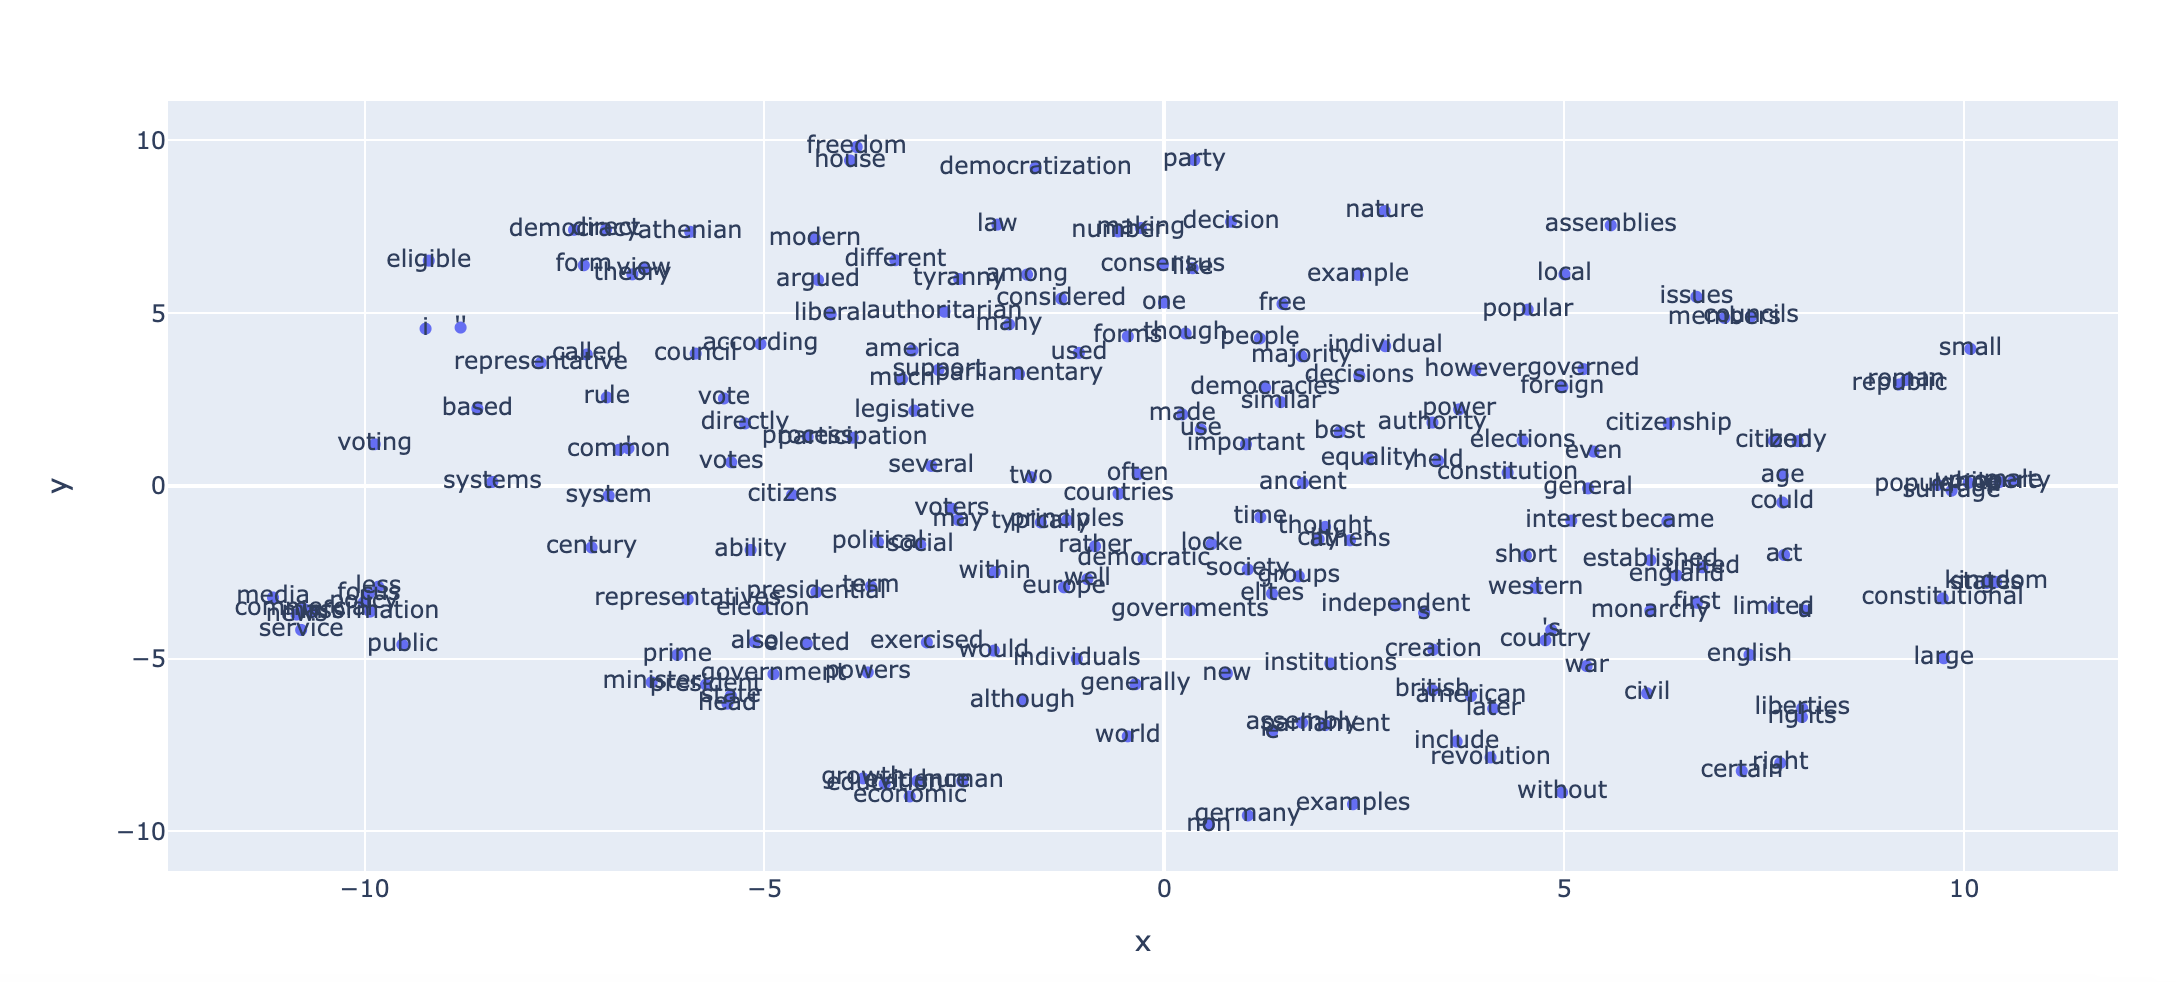

In [ ]:
# Embeddings 3D
vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

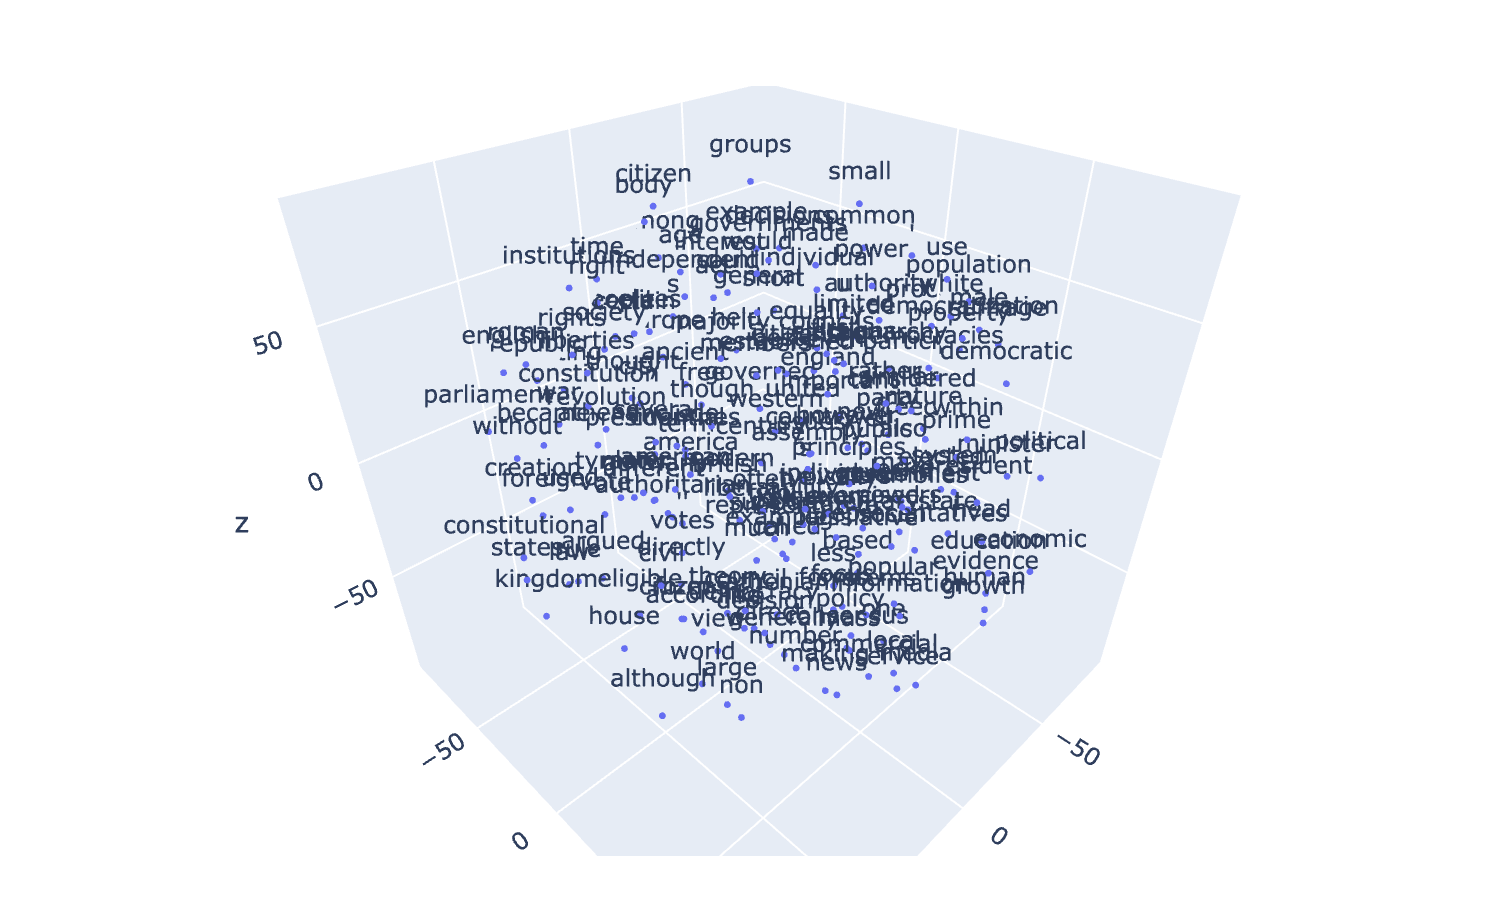

In [ ]:
# Terminos similares y antagonicos
print("\nFREEDOM")
print("Terminos que se relacionan: " ,
      [ele[0] for ele in w2v_model.wv.most_similar(positive=["freedom"], topn=10)])
print("Terminos antagonicos:",
      [ele[0] for ele in w2v_model.wv.most_similar(negative=["freedom"], topn=10)])

print("\nREPUBLIC")
print("Terminos que se relacionan: " ,
      [ele[0] for ele in w2v_model.wv.most_similar(positive=["republic"], topn=10)])
print("Terminos antagonicos:",
      [ele[0] for ele in w2v_model.wv.most_similar(negative=["republic"], topn=10)])

print("\nPOWER")
print("Terminos que se relacionan: " ,
      [ele[0] for ele in w2v_model.wv.most_similar(positive=["power"], topn=10)])
print("Terminos antagonicos:",
      [ele[0] for ele in w2v_model.wv.most_similar(negative=["power"], topn=10)])

print("\nVOTE")
print("Terminos que se relacionan: " ,
      [ele[0] for ele in w2v_model.wv.most_similar(positive=["vote"], topn=10)])
print("Terminos antagonicos:",
      [ele[0] for ele in w2v_model.wv.most_similar(negative=["vote"], topn=10)])


FREEDOM
Terminos que se relacionan:  ['speech', 'house', 'personal', 'free', 'best', 'assembly', 'representation', 'argued', 'elections', 'according']
Terminos antagonicos: ['revolution', 'media', 'news', 'head', 'face', 'prime', 'i', 'making', 'service', 'decision']

REPUBLIC
Terminos que se relacionan:  ['roman', 'bc', '157', 'republican', '10', 'athens', 'early', 'often', 'outside', 'governance']
Terminos antagonicos: ['revolution', 'media', 'making', 'face', 'decision', 'prime', 'head', 'news', 'minister', 'service']

POWER
Terminos que se relacionan:  ['governmental', 'idea', 'authority', 'affected', 'man', 'opposed', 'societies', 'monarch', 'authoritarian', 'subject']
Terminos antagonicos: ['revolution', 'media', 'head', 'face', 'news', 'prime', 'minister', 'i', 'service', 'decision']

VOTE
Terminos que se relacionan:  ['person', 'processes', 'policies', 'affected', 'make', 'man', '157', '10', 'interests', 'given']
Terminos antagonicos: ['revolution', 'head', 'face', 'media', 'p

##### Conclusiones
- Repetición de términos antagonistas: La repetición de los términos antagonistas en todas las palabras clave puede sugerir una sobre-representación de estos términos en el corpus de entrenamiento, o que estos términos, siendo amplios y generalmente aplicables a muchos contextos, no tienen una relación exclusivamente negativa con las palabras clave.

- Relación histórica y fundamental con los términos: Las palabras clave "FREEDOM" y "REPUBLIC" muestran fuertes conexiones con términos históricos y fundamentales relacionados con los derechos y la gobernanza.

- Connotaciones de los términos: Algunos términos relacionados y antagonistas pueden llevar connotaciones positivas o negativas según el contexto, lo que resalta la complejidad de interpretar relaciones semánticas solo a través de análisis de embeddings de palabras.